# DOCUMENT SIMILARITY: DOC2VEC

### Importing Packages

In [1]:
#Importing Various packages --
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import json
from pandas.io.json import json_normalize

# --- NLTK PACKAGE ---
import nltk
# Tokenizers
from nltk.tokenize import word_tokenize, sent_tokenize, PunktSentenceTokenizer, RegexpTokenizer
# Stemming and Lemmatizing
from nltk.stem import PorterStemmer, WordNetLemmatizer
# Stopwords
from nltk.corpus import stopwords, state_union, brown, movie_reviews, treebank

# --- GENSIM PACKAGE ---
import gensim, logging
from gensim.models import Word2Vec, doc2vec, Doc2Vec


%matplotlib inline

### Loading Datasets

In [2]:
train_v1 = pd.read_json('../data/train-v1.1.json')
test_v1 = pd.read_json('../data/dev-v1.1.json')
squad_train = pd.read_json('../data/squad_train_doc.json')
squad_test = pd.read_json('../data/squad_dev_doc.json')

In [3]:
data_train = squad_train

In [4]:
data_train.rename(columns={'passages': 'documents'}, inplace=True)

In [5]:
data_train.head()

,documents,title
0,"[{'context': 'Architecturally, the school has ...",University_of_Notre_Dame
1,[{'context': 'Beyoncé Giselle Knowles-Carter (...,Beyoncé
2,[{'context': 'Montana i/mɒnˈtænə/ is a state i...,Montana
3,"[{'context': 'The phrase ""in whole or in part""...",Genocide
4,[{'context': 'The emergence of resistance of b...,Antibiotics


### Documents List

In [6]:
title_list = [data_train.title[i] for i in range(data_train.shape[0])]

### Segregating Dataframe

In [7]:
## Returns list of all context and list of all question sets

def get_compact_dataframe():
    context_list = []
    question_list = []
    
    for doc in data_train.documents:
        context_list.append(get_each_context_each_questionSet(doc)[0])
        question_list.append(get_each_context_each_questionSet(doc)[1])
    
    return context_list, question_list

In [8]:
## Pass a document and it returns list of context and list of set of questions

def get_each_context_each_questionSet(document):
    each_doc_context_list = [document[i]['context'] for i in range(len(document))]
    each_doc_question_list = [document[i]['questions'] for i in range(len(document))]
    return  each_doc_context_list, each_doc_question_list

In [9]:
context_list, question_list = get_compact_dataframe()[0], get_compact_dataframe()[1]
compact_dataframe = pd.DataFrame({'title':title_list, 'context':context_list, 'questions': question_list})

## DATAFRAME

In [10]:
compact_dataframe.head()

,context,questions,title
0,"[Architecturally, the school has a Catholic ch...","[[What is the Grotto at Notre Dame?, To whom d...",University_of_Notre_Dame
1,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,[[In what city and state did Beyonce grow up?...,Beyoncé
2,[Montana i/mɒnˈtænə/ is a state in the Western...,"[[What is its rank in popularion?, What is the...",Montana
3,"[The phrase ""in whole or in part"" has been sub...",[[Which phrase is especially contentious withi...,Genocide
4,[The emergence of resistance of bacteria to an...,[[What is the purpose of antibiotic treatment?...,Antibiotics


In [11]:
compact_dataframe[compact_dataframe.title == '2008_Sichuan_earthquake']

,context,questions,title
10,[The 2008 Sichuan earthquake or the Great Sich...,"[[What time of the day did the quake happen?, ...",2008_Sichuan_earthquake


#### TOTAL QUESTIONS

In [12]:
list_questions_perDOC = []
count = 0

for each_doc_question in compact_dataframe.questions:

    Doc_questions = []
    for each_Set in each_doc_question:
        for each_question in each_Set:
            Doc_questions.append(each_question)
            count +=1
    
    list_questions_perDOC.append(Doc_questions)

In [13]:
print("Total Questions = ", count)

Total Questions =  87433


In [14]:
c = [len(list_questions_perDOC[i]) for i in range(10,11)]

In [15]:
sum(c)

518

----

### Implementing Gensim 

In [16]:
class DocIterator(object):
    
    ## Initailizes document's list(doc1,doc2...) and its label's list('Book_1','Book_2',...)
    def __init__(self, doc_list, labels_list):
        self.doc_list = doc_list
        self.labels_list = labels_list
    
    ## Assigns label1 to a list of all words in doc1, label2 to all words in doc2, etc.
    def __iter__(self):
        
        for idx, doc in enumerate(self.doc_list):
            yield doc2vec.LabeledSentence(words=doc.split(), tags=[self.labels_list[idx]])

In [17]:
## Contains the whole data

data = []
docLabels = title_list

for i in docLabels:
    x = compact_dataframe[compact_dataframe.title == i].context.sum()
    y = ' '.join(x)
    data.append(y)

In [18]:
iter_docs = DocIterator(data, docLabels)

##### Model

In [32]:
model = Doc2Vec(iter_docs, size=200, window=50, min_count=1, workers=11, alpha=0.025, min_alpha=0.025, dbow_words = 1, iter = 20)

----

## TESTING

In [33]:
test = 'What is the Grotto at Notre Dame?'
words = word_tokenize(test)

##### INFER

In [34]:
new_doc_vec = model.infer_vector(words)
model.docvecs.most_similar([new_doc_vec], topn=10)

[('Southern_Europe', 0.5372093915939331),
 ('Liberia', 0.5241061449050903),
 ('Armenians', 0.5228872895240784),
 ('Geography_of_the_United_States', 0.519429087638855),
 ('Canon_law', 0.5191516280174255),
 ('Mali', 0.5170228481292725),
 ('Heresy', 0.5160000920295715),
 ('Crucifixion_of_Jesus', 0.5029048919677734),
 ('Christian', 0.4957031309604645),
 ('Mary_(mother_of_Jesus)', 0.4951178729534149)]

##### CENTROID

In [37]:
avg_sentence = np.zeros((200))
count = 0
for word in words:
    if word in model.wv.vocab:
        avg_sentence += model[word]
        count+=1
avg_sentence = avg_sentence / count

model.docvecs.most_similar([avg_sentence], topn=10)

[('University_of_Notre_Dame', 0.5920661687850952),
 ('Yale_University', 0.31637150049209595),
 ('Order_of_the_British_Empire', 0.3118094205856323),
 ('Freemasonry', 0.3073330521583557),
 ('University_of_Kansas', 0.30294978618621826),
 ('Northwestern_University', 0.29932448267936707),
 ('Washington_University_in_St._Louis', 0.2948078513145447),
 ('Pitch_(music)', 0.29364120960235596),
 ('Brigham_Young_University', 0.2860960066318512),
 ('List_of_numbered_streets_in_Manhattan', 0.28540152311325073)]

### TOTAL ACCURACY CHECK

In [39]:
## Accuracy Check:

total_questions1 = []
total_questions2 = []
cent_questions = []
infer_questions = []

for index in range(50):
    
    simi_CENT = similarity_question(list_questions_perDOC[index])[0]
    simi_INFER = similarity_question(list_questions_perDOC[index])[1] 
    
    count1 = 0
    total_count1 = 0

    
    for i in simi_CENT:
        total_count1+=1
        for each_doc in i:
            if each_doc[0] == title_list[index]:
                count1+=1
    
    total_questions1.append(total_count1)
    cent_questions.append(count1)
    
    count2 = 0
    total_count2 = 0

    for i in simi_INFER:

        total_count2+=1
        for each_doc in i:
            if each_doc[0] == title_list[index]:
                count2+=1
                
    total_questions2.append(total_count2)
    infer_questions.append(count2)

#### Question - Document Similarity Check

In [38]:
def similarity_question(doc):
    
    similarity_matrix_CENTROID = []
    similarity_matrix_INFER = []
    
    for each_question in doc:

        # CENTROID METHOD
        avg_sentence = np.zeros((200))
        count = 0
        for word in word_tokenize(each_question):
            if word in model.wv.vocab:
                avg_sentence += model[word]
                count+=1
        avg_sentence = avg_sentence / count
        similarity_matrix_CENTROID.append(model.docvecs.most_similar([avg_sentence], topn=5))
            
        # INFER METHOD
        new_doc_vec = model.infer_vector(word_tokenize(each_question))
        similarity_matrix_INFER.append(model.docvecs.most_similar([new_doc_vec], topn=5))
    
    
    return similarity_matrix_CENTROID, similarity_matrix_INFER

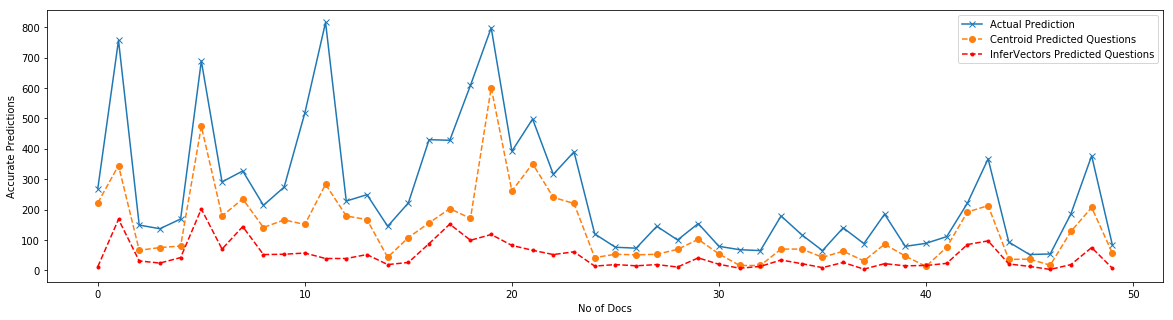

In [41]:
doc_size = [i for i in range(50)]

pl.figure(figsize=(20,5))
pl.plot(doc_size, total_questions1, marker='x', label='Actual Prediction')
pl.plot(doc_size, cent_questions, marker='o', linestyle='--', label='Centroid Predicted Questions')
pl.plot(doc_size, infer_questions, marker='.', linestyle='--', color='r', label='InferVectors Predicted Questions')
pl.xlabel('No of Docs')
pl.ylabel('Accurate Predictions')
pl.legend()
pl.show()

#### ACCURACY

In [42]:
## OVERALL ACC
np.mean([cent/total*100 for cent,total in zip(cent_questions, total_questions1)])

54.449201488581174

In [43]:
np.mean([infer/total*100 for infer,total in zip(infer_questions, total_questions1)])

18.542393616739773

In [44]:
## ACC
np.mean([cent/total*100 for cent,total in zip(cent_questions, total_questions1)])

54.449201488581174

In [45]:
np.mean([infer/total*100 for infer,total in zip(infer_questions, total_questions1)])

18.542393616739773

-----

----

# WMD

In [57]:
from gensim.models import KeyedVectors

In [58]:
model_Google = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [123]:
dd = word_tokenize(' '.join(compact_dataframe.context[1]))

In [126]:
sent = word_tokenize('What is Grotto at Norte Dame?')
sent

['What', 'is', 'Grotto', 'at', 'Norte', 'Dame', '?']

In [128]:
answer_value = model_Google.wmdistance(sentt, word_tokenize(' '.join(compact_dataframe.context[0])))
answer_value

3.257375125384118

In [129]:
for i in range(100):
    
    context_words = word_tokenize(' '.join(compact_dataframe.context[i]))
    dist = model_Google.wmdistance(sent, context_words)
    
    if dist < answer_value:
        answer_value = dist

In [130]:
answer_value

3.213526215918507

In [136]:
d = list_questions_perDOC[0]
d[0]

'What is the Grotto at Notre Dame?'

In [138]:
for index in range(1):
    
    for each_question in list_questions_perDOC[index]:
        
        sentence1 = word_tokenize(each_question)
        sentence2 = word_tokenize(' '.join(compact_dataframe.context[index]))
        
        answer_value = model_Google.wmdistance(sentence1, )        
        

What is the Grotto at Notre Dame?
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
What sits on top of the Main Building at Notre Dame?
The Basilica of the Sacred heart at Notre Dame is beside to which structure?
What is in front of the Notre Dame Main Building?
What is the daily student paper at Notre Dame called?
In what year did the student paper Common Sense begin publication at Notre Dame?
When did the Scholastic Magazine of Notre dame begin publishing?
How many student news papers are found at Notre Dame?
How often is Notre Dame's the Juggler published?
What is the oldest structure at Notre Dame?
What individuals live at Fatima House at Notre Dame?
What is the primary seminary of the Congregation of the Holy Cross?
Which prize did Frederick Buechner create?
Where is the headquarters of the Congregation of the Holy Cross?
How many BS level degrees are offered in the College of Engineering at Notre Dame?
In what year was the College of Engineering at Notre Da